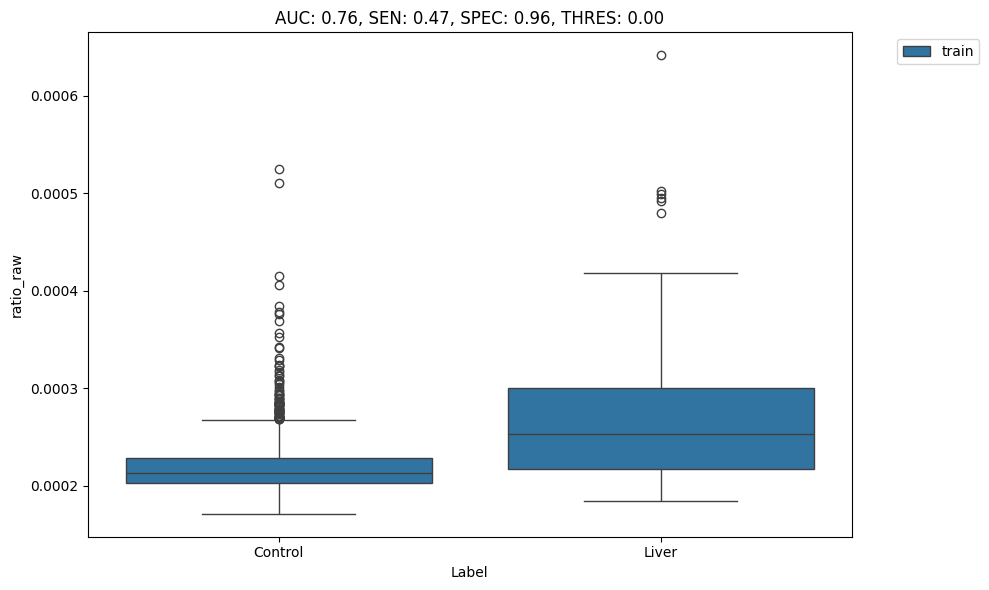

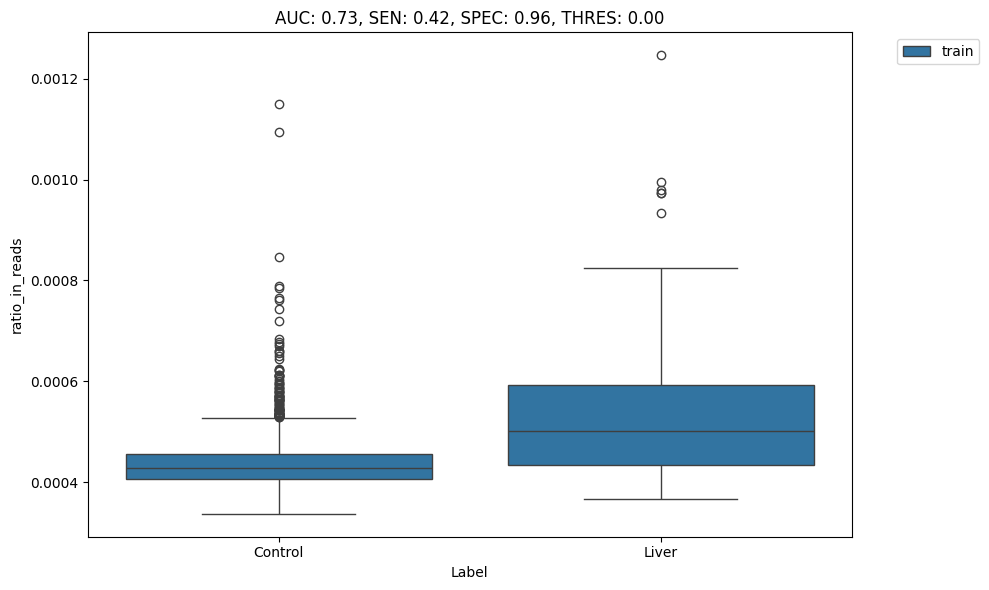

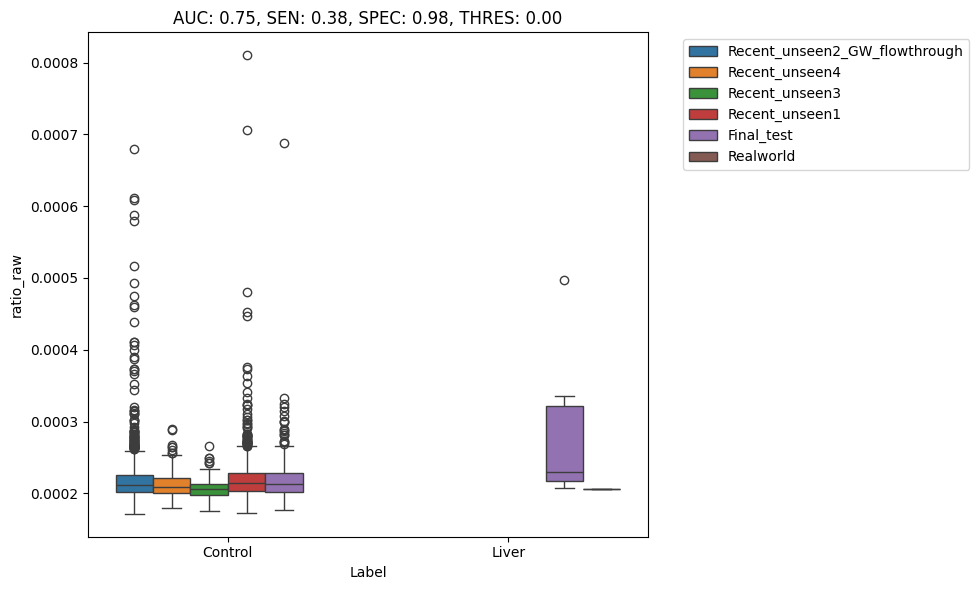

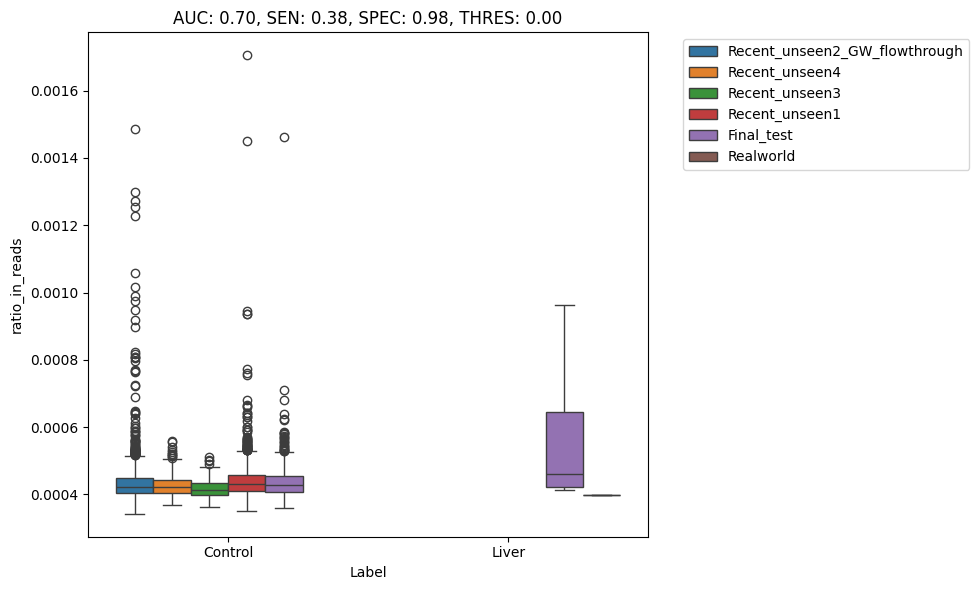

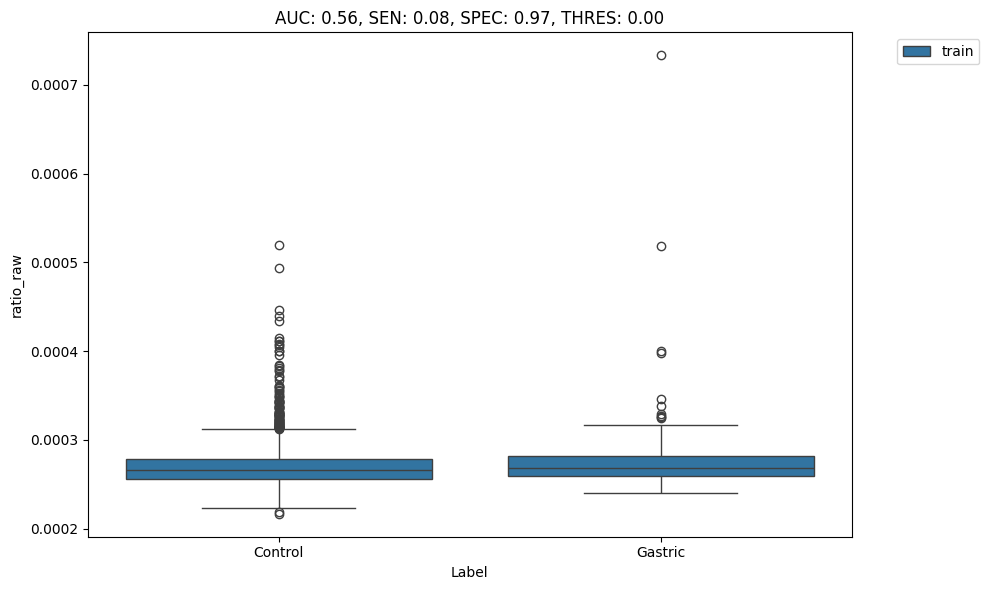

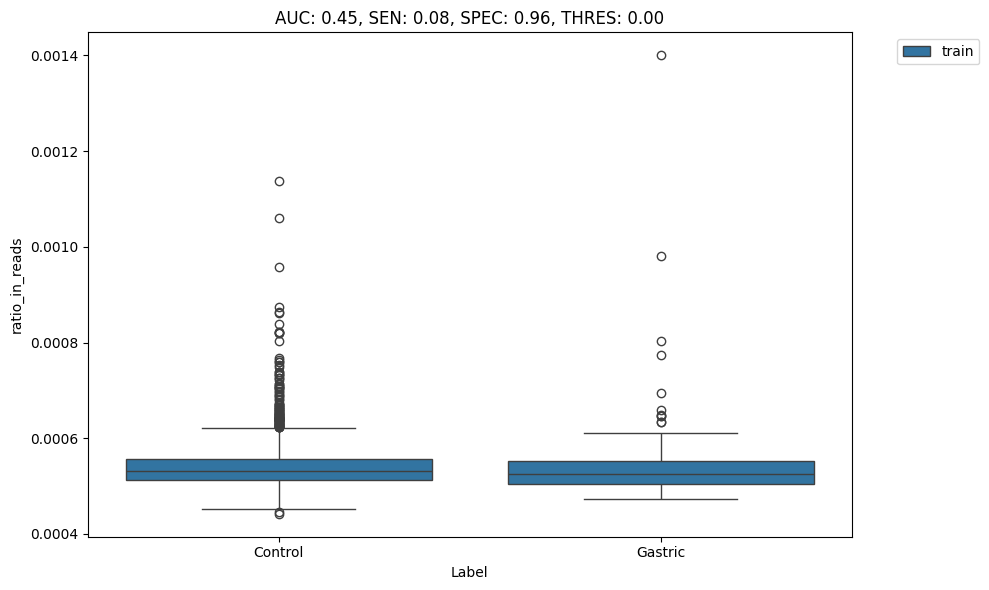

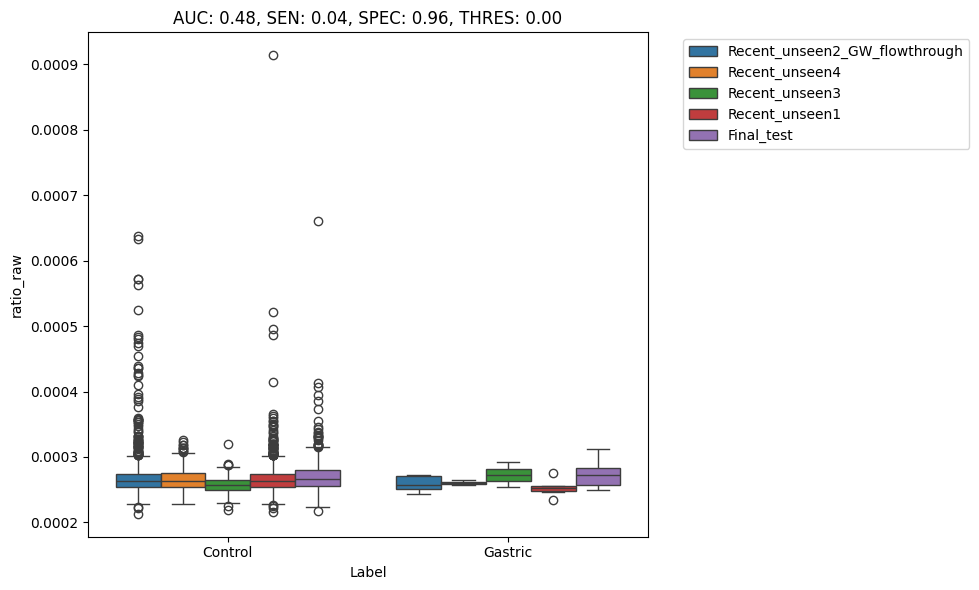

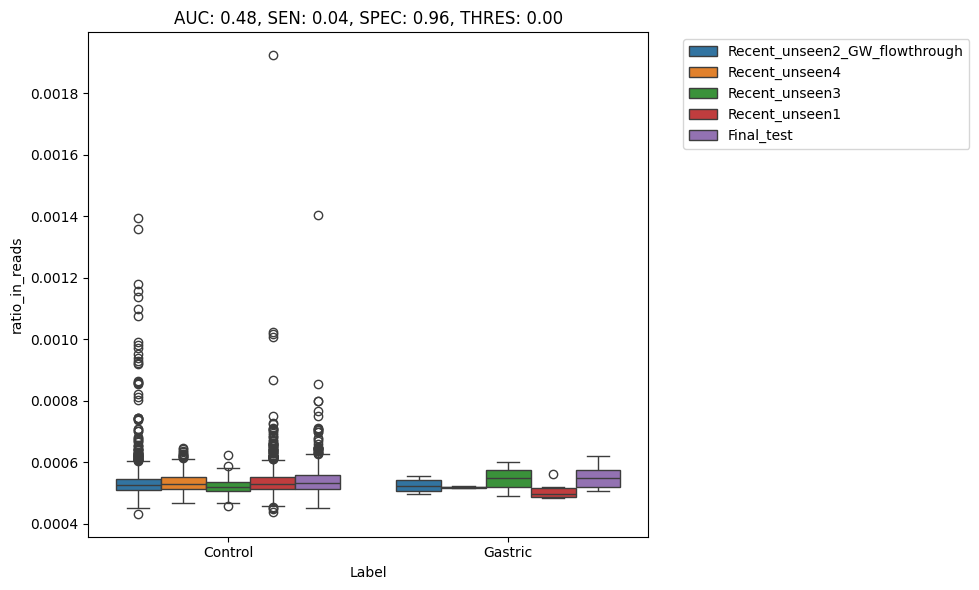

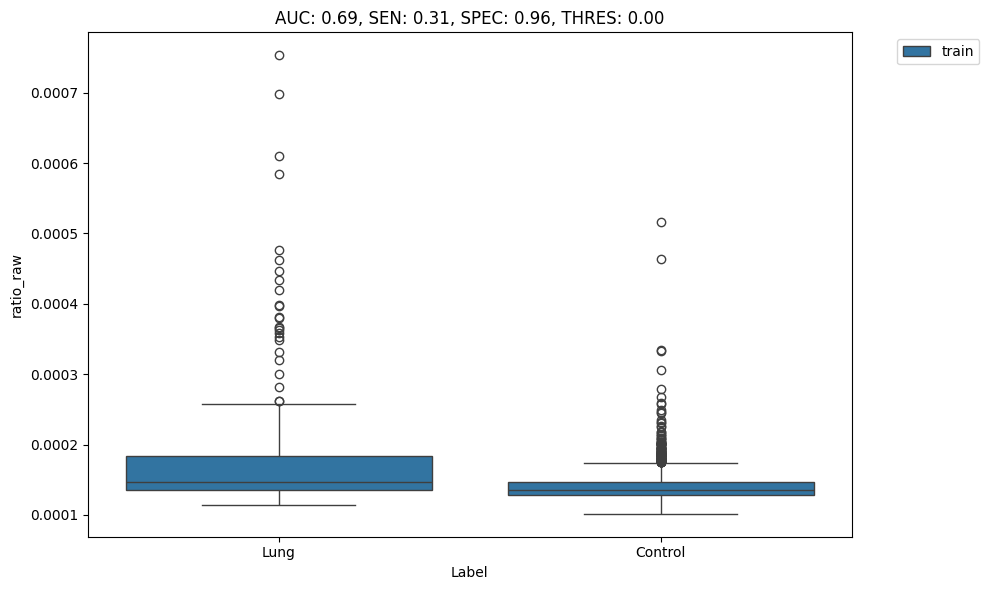

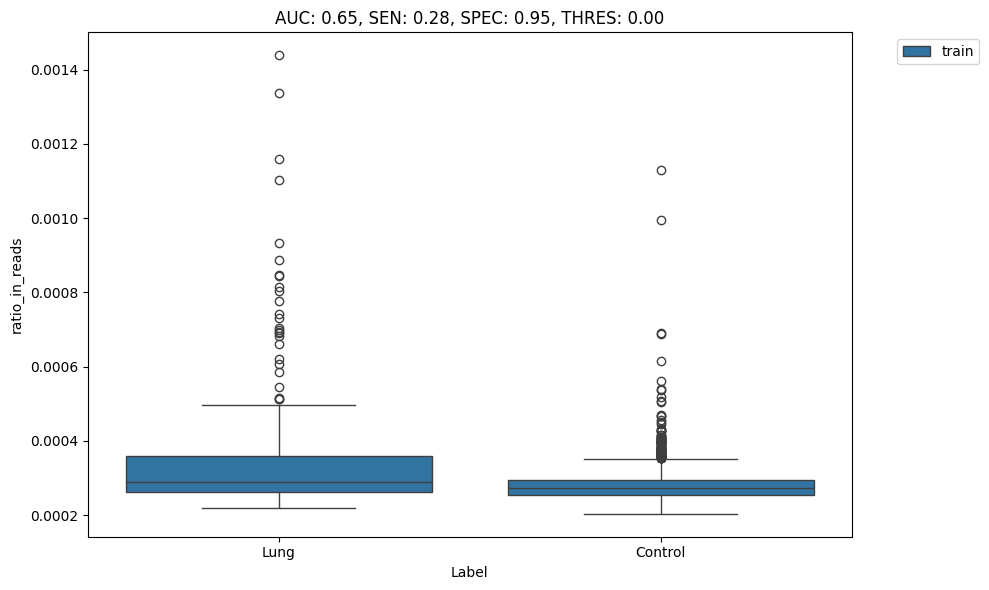

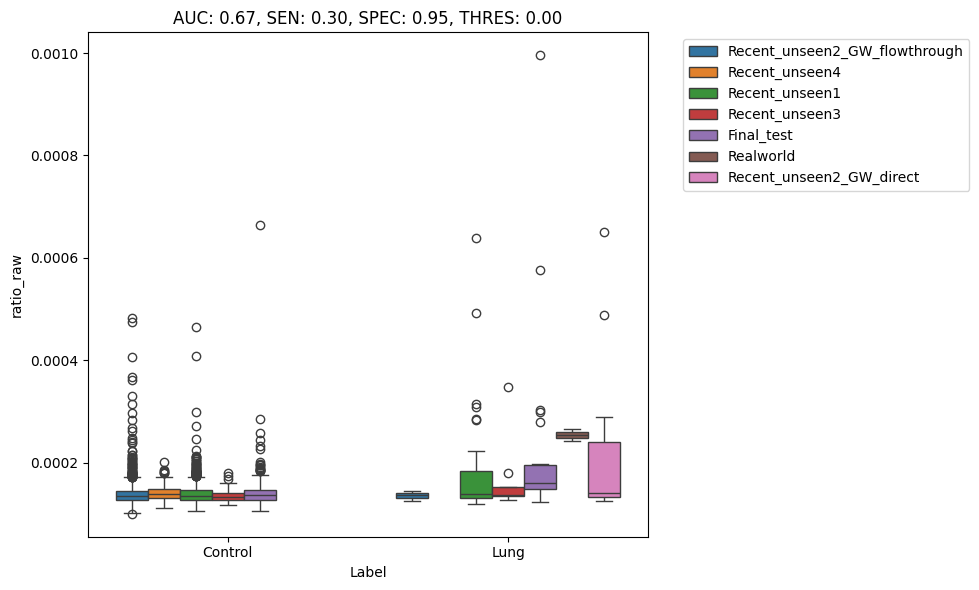

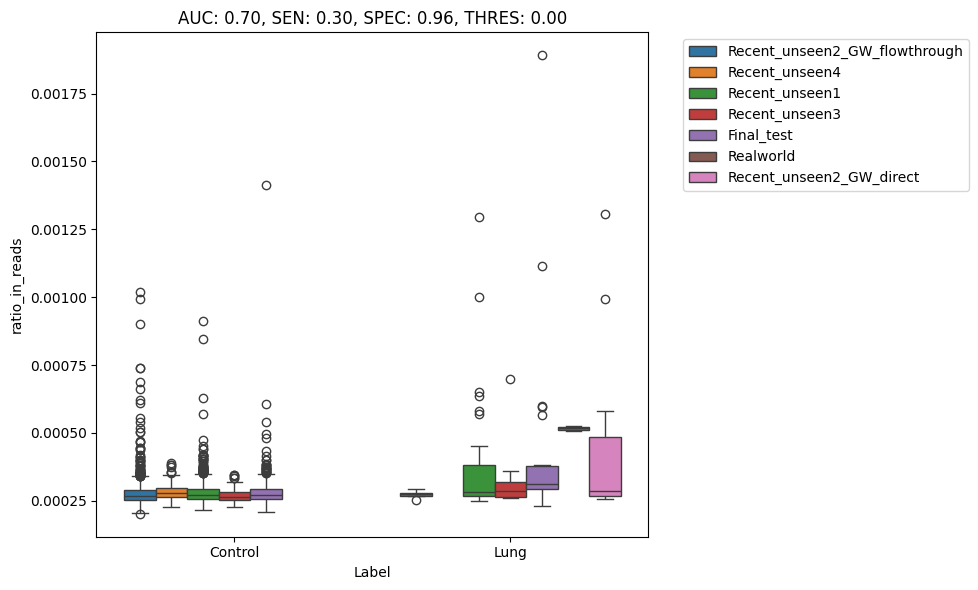

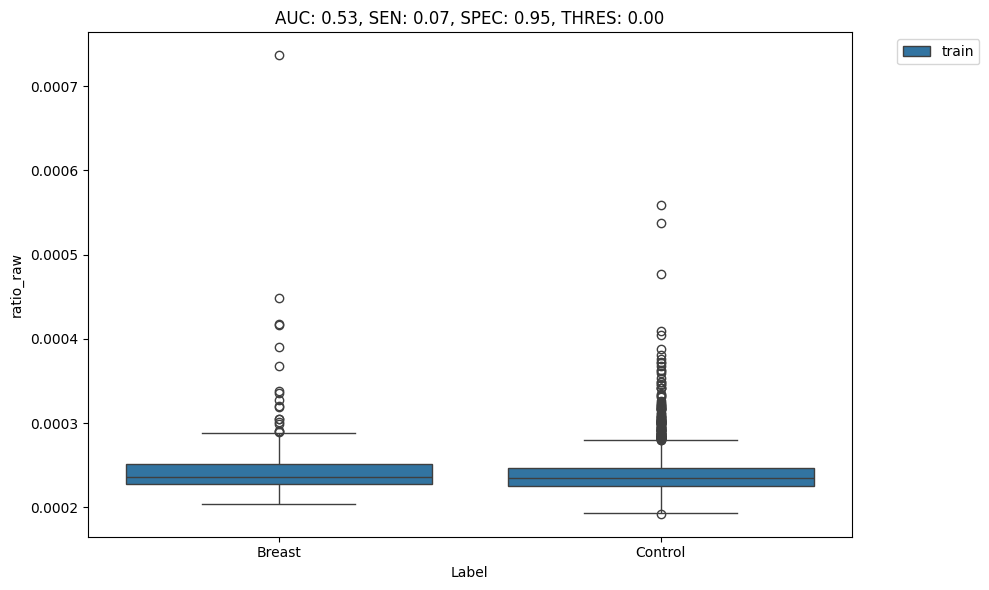

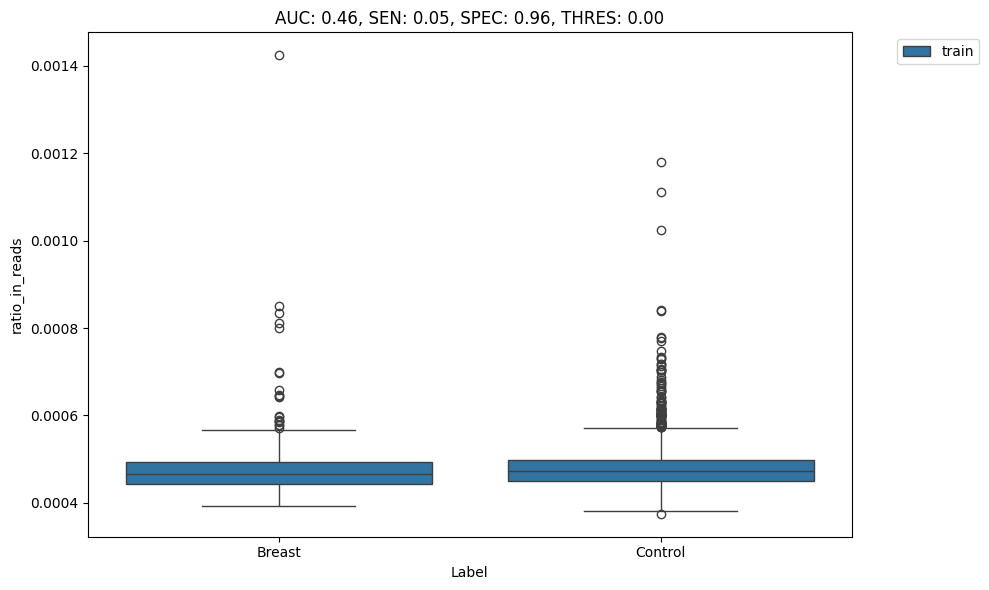

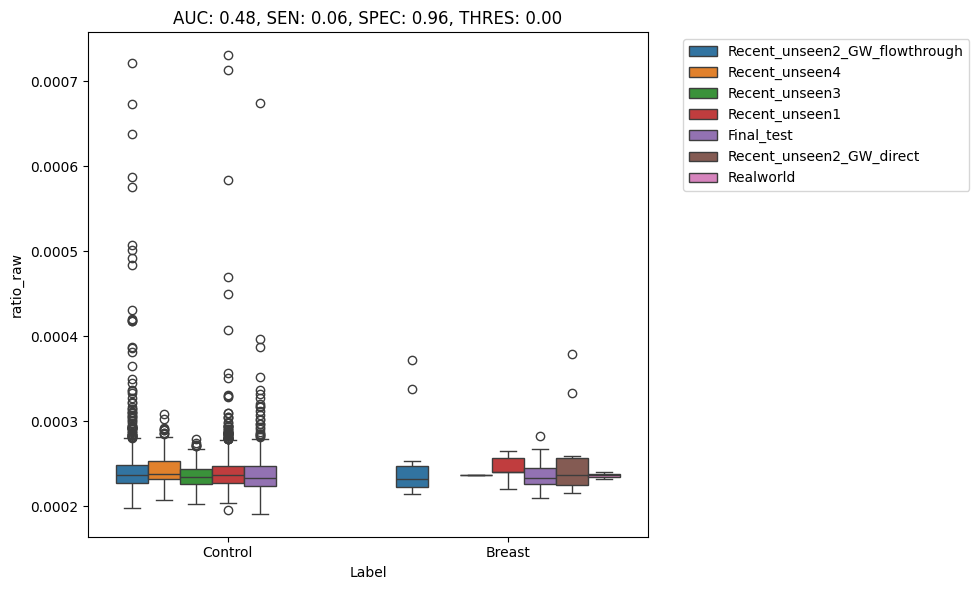

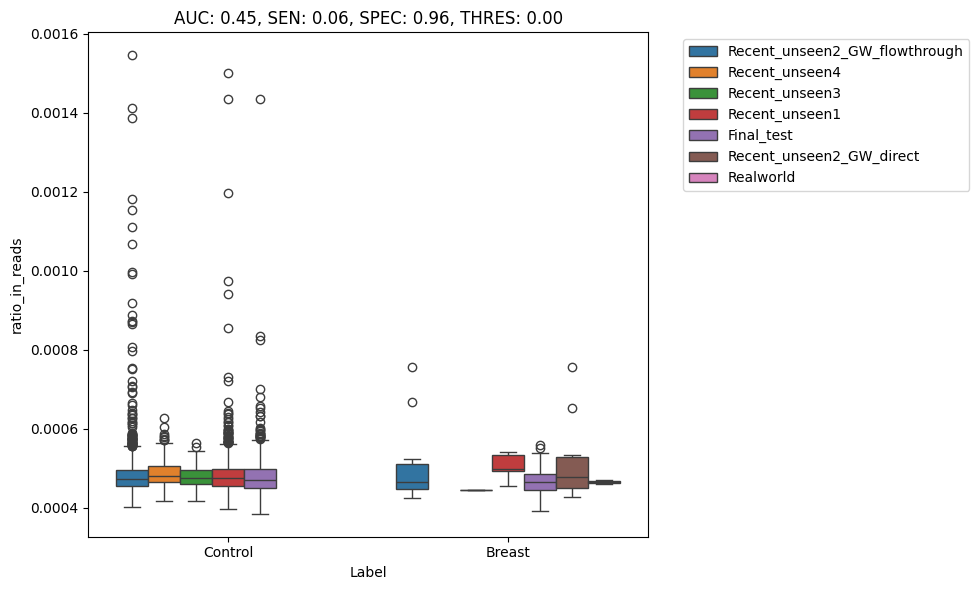

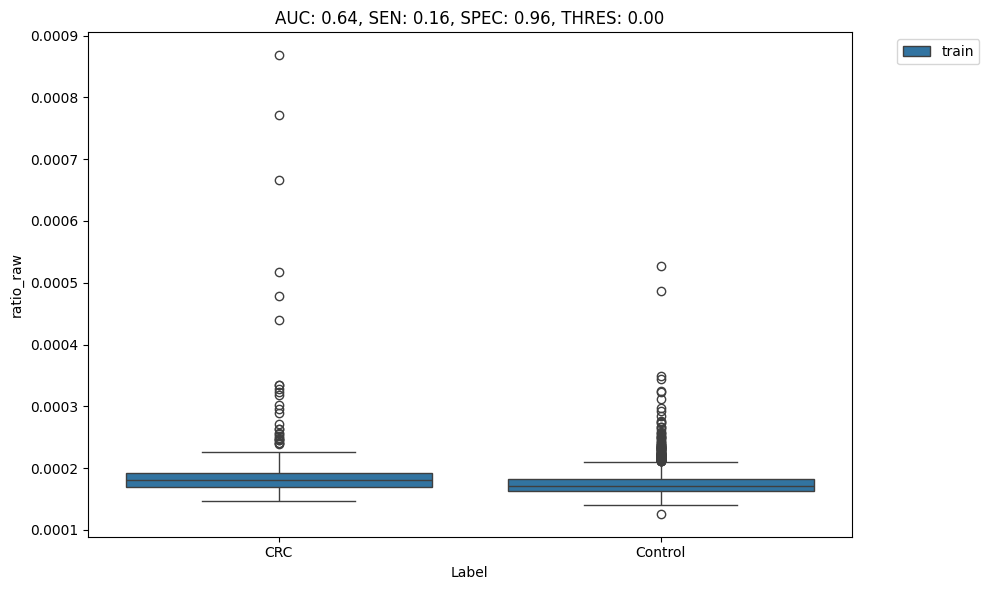

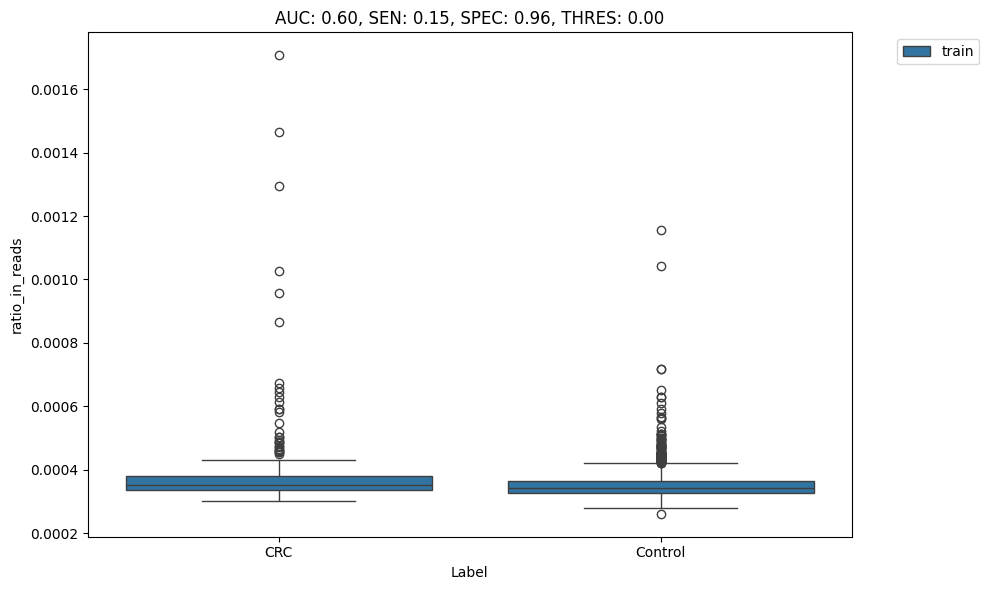

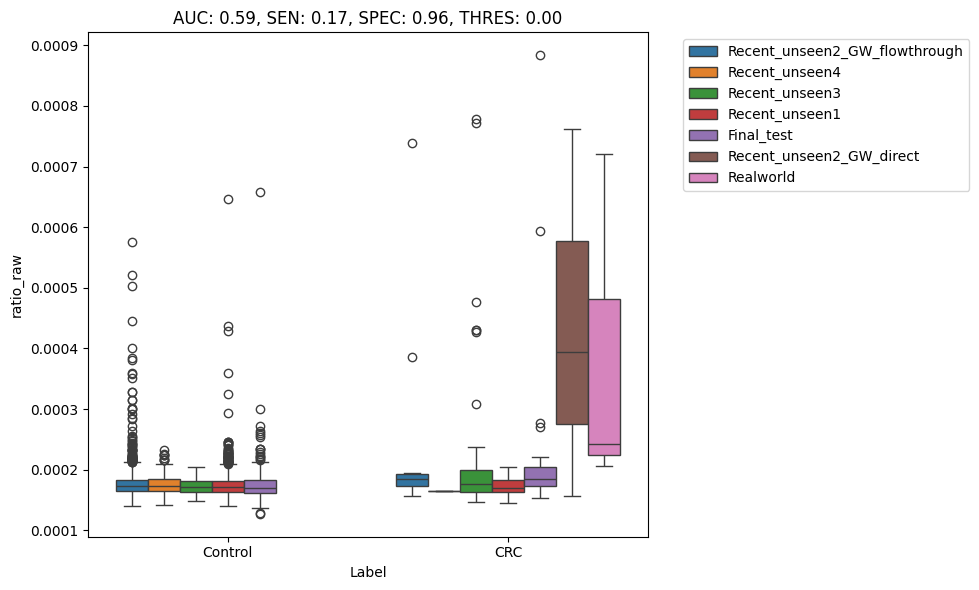

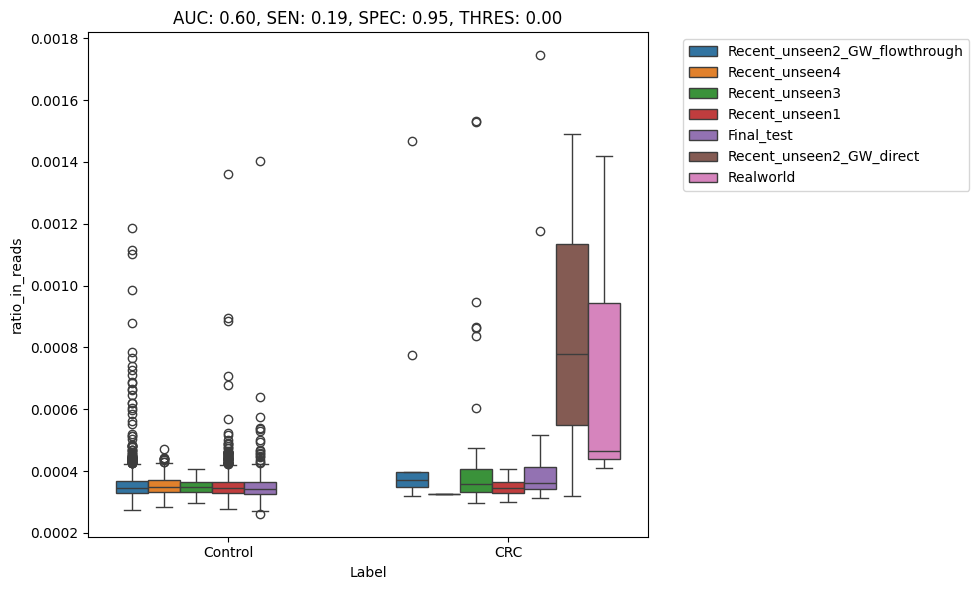

In [1]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

# input_cancer_class = "Gastric"
all_cancer_classes = ["Liver", "Gastric", "Lung", "Breast", "CRC"]
for input_cancer_class in all_cancer_classes:
    path_to_main_output = os.path.join(outdir, PROJECT, output_version)
    path_to_03_output = os.path.join(path_to_main_output, "03_output", input_cancer_class)
    path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

    os.system(f"mkdir -p {path_to_08_output}")

    metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
    metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

    all_files = [item for item in pathlib.Path(path_to_07_output).glob("*.candi_reads.csv")]
    countdf = pd.read_csv(os.path.join(path_to_07_output, "all_count.csv"), index_col = [0])

    all_samples = []
    all_mean_candi_reads = []
    for file in all_files:
        tmpdf = pd.read_csv(file)
        mean_candi_reads = tmpdf.candi_reads.mean()
        all_samples.append(file.name.split(".")[0])
        all_mean_candi_reads.append(mean_candi_reads)

    candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
    candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
    candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
    candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
    candidf = candidf.merge(metadata[["SampleID", "Label", "Set"]], right_on = "SampleID", left_on = "SampleID")
    candidf.to_excel(os.path.join(path_to_08_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)), index = False)

    #####-------------------------------------------------------------#####
    ##### summary model metrics on training set.
    #####-------------------------------------------------------------#####
    candidf_train = candidf[candidf["Set"] == "train"].copy()
    candidf_test = candidf[candidf["Set"] != "train"].copy()
    
    # Calculate the ROC curve for the values ratio_raw
    def plot_roc_curve(inputdf, figname1, figname2, selected_spec_ratio_raw = None, selected_spec_ratio_in_reads = None):
        fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_raw'])
        num_cancer = inputdf[inputdf["Label"] == input_cancer_class].shape[0]
        num_control = inputdf[inputdf["Label"] != input_cancer_class].shape[0]

        if (selected_spec_ratio_raw is None) or (selected_spec_ratio_in_reads is None):
            aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
            aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

            selected_thres_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
            selected_spec_ratio_raw = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
            selected_sens_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

            # Calculate the AUC
            roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
            title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_raw:.2f}, SPEC: {selected_spec_ratio_raw:.2f}, THRES: {selected_thres_ratio_raw:.2f}"

            # Calculate the ROC curve for the values ratio_in_reads
            fpr_ratio_in_reads, tpr_ratio_in_reads, thres_ratio_in_reads = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_in_reads'])
            aucdf = pd.DataFrame({"fpr": fpr_ratio_in_reads, "tpr": tpr_ratio_in_reads, "thres": thres_ratio_in_reads})
            aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

            selected_thres_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
            selected_spec_ratio_in_reads = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
            selected_sens_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

            # Calculate the AUC
            roc_auc = auc(fpr_ratio_in_reads, tpr_ratio_in_reads)
            title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_in_reads:.2f}, SPEC: {selected_spec_ratio_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.2f}"
        else:
            inputdf["prediction_raw"] = inputdf["ratio_raw"].apply(lambda x: 1 if x >= selected_spec_ratio_raw else 0)
            inputdf["prediction_in_reads"] = inputdf["ratio_in_reads"].apply(lambda x: 1 if x >= selected_spec_ratio_in_reads else 0)
            
            SEN_raw = inputdf[(inputdf["prediction_raw"] == 1) & (input["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
            SPEC_raw = inputdf[(inputdf["prediction_raw"] == 0) & (input["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

            SEN_in_reads = inputdf[(inputdf["prediction_in_reads"] == 1) & (input["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
            SPEC_in_reads = inputdf[(inputdf["prediction_in_reads"] == 0) & (input["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

            title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_raw:.2f}, SPEC: {SPEC_raw:.2f}, THRES: {selected_thres_ratio_raw:.2f}"
            title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_in_reads:.2f}, SPEC: {SPEC_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.2f}"

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=inputdf, x="Label", y="ratio_raw", hue="Set")
        plt.title(title_raw)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_08_output, figname1), format='svg')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=inputdf, x="Label", y="ratio_in_reads", hue="Set")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(title_in_reads)
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_08_output, figname2), format='svg')
        plt.show()
    
    plot_roc_curve(candidf_train, "boxplot_ratio_candi_to_raw_counts.train.svg", "boxplot_ratio_candi_to_inside_read_counts.train.svg")
    plot_roc_curve(candidf_test, "boxplot_ratio_candi_to_raw_counts.train.svg", "boxplot_ratio_candi_to_inside_read_counts.train.svg")




In [5]:
inputdf

,SampleID,num_candi_reads,raw_count,in_read_count,ratio_raw,ratio_in_reads,Label,Set
0,LBC018,6.315217,41512,20030,0.000152,0.000315,CRC,train
2,K0657R1,5.345455,30355,15807,0.000176,0.000338,Control,train
4,KABR51,6.443223,43197,20630,0.000149,0.000312,Control,train
5,KZAK09,8.703971,50666,25459,0.000172,0.000342,Control,train
6,KZAB12,5.393502,34007,16945,0.000159,0.000318,Control,train
...,...,...,...,...,...,...,...,...
6195,KZAW35,4.752727,29785,14267,0.000160,0.000333,Control,train
6196,K0AE32,4.413043,25615,12432,0.000172,0.000355,Control,train
6197,KZAG12,2.347826,14436,6865,0.000163,0.000342,Control,train
6198,K1232,10.193548,58201,29918,0.000175,0.000341,Control,train
